In [1]:
# source : https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py
'''This script loads pre-trained word embeddings (GloVe embeddings)
into a frozen Keras Embedding layer, and uses it to
train a text classification model on the 20 Newsgroup dataset
(classification of newsgroup messages into 20 different categories).

GloVe embedding data can be found at:
http://nlp.stanford.edu/data/glove.6B.zip
(source page: http://nlp.stanford.edu/projects/glove/)

FastText embedding data can be found at:
https://fasttext.cc/docs/en/english-vectors.html

dict2vec embedding data can be found at:
https://github.com/tca19/dict2vec

20 Newsgroup data can be found at:
http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.html
'''

from __future__ import print_function

import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant

cwd = os.getcwd()
BASE_DIR = r'D:\Users\Baptiste\Documents\Telecom_Saint-Etienne\FISE_3\PRI\Classification'
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
FASTTEXT_DIR = os.path.join(BASE_DIR, 'fasttext\wiki-news-300d-1M-subword.vec')
DICT2VEC_DIR = os.path.join(BASE_DIR, 'dict2vec\dict2vec-vectors-dim100.vec')
TEXT_DATA_DIR = os.path.join(cwd, 'training_data')
MAX_SEQUENCE_LENGTH = 500
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
NUMBER_OF_USED_METADATA = 3

Using TensorFlow backend.


In [3]:
def load_glove(fname):
    embeddings_index = {}
    with open(os.path.join(fname, 'glove.6B.100d.txt'), encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index       
    

In [2]:
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

# Embedding vector

In [3]:
# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

#embeddings_index = load_glove(GLOVE_DIR)
embeddings_index = load_vectors(DICT2VEC_DIR)

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 132922 word vectors.


# Load the dataset

In [4]:
import bibtexparser
from bibtexparser.bparser import BibTexParser

#with open('training_data/codebasedcryptocayrelnet.bib') as bibtex_file:
#    bib_database = bibtexparser.load(bibtex_file)

# second, prepare text samples and their labels
print('Processing text dataset')

#texts = []  # list of text samples
x_title = []
x_keywords = []
x_booktitle = []
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids

#name = "Articles_divers"
#label_id = len(labels_index)
#labels_index[name] = label_id
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            #if fname.isdigit():
            fpath = os.path.join(path, fname)
            #    args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
                #with open(fpath, **args) as f:
                #    t = f.read()
                #    i = t.find('\n\n')  # skip header
                #    if 0 < i:
                #        t = t[i:]
                #    texts.append(t)
                #labels.append(label_id)
            with open(fpath) as bibtex_file:
                parser = BibTexParser(interpolate_strings=False)

                bib_database = bibtexparser.load(bibtex_file, parser)
                for publi in bib_database.entries:
                    title = publi['title'].lower().replace("{}", "")
                    if "keywords" in  publi:
                        keywords = publi['keywords'].lower().replace("{}", "")
                    else:
                        keywords = ""
                    if "booktitle" in  publi:
                        booktitle = publi['booktitle'].lower().replace("{}", "")
                    else:
                        booktitle = ""
                    x_title.append(title)
                    x_keywords.append(keywords)
                    x_booktitle.append(booktitle)
                    labels.append(label_id)

# Classes
#name = "Articles_cryptographie"
#label_id = len(labels_index)
#labels_index[name] = label_id

#for publi in bib_database.entries:
#    title = publi['title'].lower().replace("{}", "")
#    texts.append(title)
#    labels.append(label_id)

print('Found %s texts.' % len(x_title))
#labels_index

Processing text dataset


Entry type thesis not standard. Not considered.


Found 380 texts.


In [5]:
labels_index

{'Crypto': 0, 'Others': 1}

In [22]:
#texts
x_title

["security-related comments regarding {mceliece} 's public-key cryptosystem",
 'a new efficient threshold ring signature scheme based on coding theory',
 'a new zero-knowledge code based identification scheme with reduced\ncommunication',
 'susceptibility of digital signature schemes based on error-correcting\ncodes to universal forgery',
 'a digital signature scheme based on linear error-correcting block\ncodes',
 'security of {xinmei} digital signature scheme',
 'cryptanalysis of the {harn} and {wang} modification of the {xinmei}\ndigital signature scheme',
 'digital signature scheme based on error-correcting codes',
 'improved identity-based identification and signature schemes using\nquasi-dyadic {goppa} codes',
 'on constructing homomorphic encryption schemes from coding theory',
 'minimal vectors in linear codes',
 '{sha-3} proposal : {fsb}',
 'a family of fast syndrome based cryptographic hash functions',
 'a fast provably secure cryptographic hash function',
 'side-channel atta

In [23]:
x_keywords

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',


In [24]:
x_booktitle

['',
 'post-quantum cryptography, second international workshop, pqcrypto\n2008,{l}ecture {n}otes {c}omputer {s}cience, {s}pringer',
 'corr abs/1111.1644',
 'error control, cryptology, and speech compression. selected papers\nfrom the workshop on information protection, {l}ecture {n}otes {c}omputer\n{s}cience, {s}pringer',
 "josef pieprzyk and reihanah safavi-naini (editors). advances cryptology-asiacrypt\n'94. proceedings of the fourth international conference held at the\nuniversity of wollongong, wollongong, november 28-december 1, {l}ecture\n{n}otes {c}omputer {s}cience 917. {s}pringer",
 'electronics letters 28,',
 'electronics letters 28,',
 'chinese : acta electronica sinica 19',
 'information security and assurance international conference, isa\n2011',
 'cryptology eprint archive, report 2011/309,',
 '',
 'submission to the sha3 nist competition,',
 'ed dawson, serge vaudenay (editors). progress cryptology-mycrypt\nfirst international conference on cryptology malaysia, kuala lu

In [6]:
# finally, vectorize the text samples into a 2D integer tensor
data = []
# titles
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x_title)
sequences_title = tokenizer.texts_to_sequences(x_title)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data_title = pad_sequences(sequences_title, maxlen=MAX_SEQUENCE_LENGTH)

# keywords
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x_keywords)
sequences_keywords = tokenizer.texts_to_sequences(x_keywords)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data_keywords = pad_sequences(sequences_keywords, maxlen=MAX_SEQUENCE_LENGTH)

# booktitle
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x_booktitle)
sequences_booktitle = tokenizer.texts_to_sequences(x_booktitle)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data_booktitle = pad_sequences(sequences_booktitle, maxlen=MAX_SEQUENCE_LENGTH)

###

data.append(data_title)
data.append(data_keywords)
data.append(data_booktitle)

data = np.moveaxis(data,0,1)
data = np.reshape(data,[380,MAX_SEQUENCE_LENGTH*NUMBER_OF_USED_METADATA])

data = np.array(data)

labels_categorical = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels_categorical.shape)

Found 1228 unique tokens.
Found 758 unique tokens.
Found 676 unique tokens.
Shape of data tensor: (380, 1500)
Shape of label tensor: (380, 2)


In [30]:
#data[0]

In [7]:
# split the data into a training set and a validation set
#indices = np.arange(data.shape[0])
#np.random.shuffle(indices)
#data = data[indices]
#labels = labels[indices]
#num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

#x_train = data[:-num_validation_samples]
#y_train = labels[:-num_validation_samples]
#x_val = data[-num_validation_samples:]
#y_val = labels[-num_validation_samples:]

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(data, labels_categorical, test_size=0.2, random_state=0)


In [8]:
print('Preparing embedding matrix.')
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH*NUMBER_OF_USED_METADATA,
                            trainable=False)

Preparing embedding matrix.


TypeError: float() argument must be a string or a number, not 'map'

In [53]:
print('Create training model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH*NUMBER_OF_USED_METADATA,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

Create training model.


In [54]:
print(*[bla.shape for bla in [x_train, x_val, y_train, y_val]], sep="\n")

(304, 1500)
(76, 1500)
(304, 2)
(76, 2)


In [35]:
y_train[:10]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [55]:
import matplotlib.pyplot as plt

print('Training model')

history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_val, y_val))

Training model
Train on 304 samples, validate on 76 samples
Epoch 1/10
304/304 [==============================] - 1s 2ms/step - loss: 1.0133 - acc: 0.7434 - val_loss: 0.6174 - val_acc: 0.7237
Epoch 2/10
304/304 [==============================] - 0s 702us/step - loss: 0.5359 - acc: 0.7500 - val_loss: 0.5411 - val_acc: 0.7237
Epoch 3/10
304/304 [==============================] - 0s 709us/step - loss: 0.4463 - acc: 0.7664 - val_loss: 0.7739 - val_acc: 0.7237
Epoch 4/10
304/304 [==============================] - 0s 705us/step - loss: 0.6361 - acc: 0.6217 - val_loss: 0.5497 - val_acc: 0.7237
Epoch 5/10
304/304 [==============================] - 0s 702us/step - loss: 0.4206 - acc: 0.7862 - val_loss: 0.4178 - val_acc: 0.8026
Epoch 6/10
304/304 [==============================] - 0s 705us/step - loss: 0.3459 - acc: 0.8191 - val_loss: 0.5161 - val_acc: 0.7368
Epoch 7/10
304/304 [==============================] - 0s 705us/step - loss: 0.3499 - acc: 0.8553 - val_loss: 0.3598 - val_acc: 0.8684
Epoc

plot model


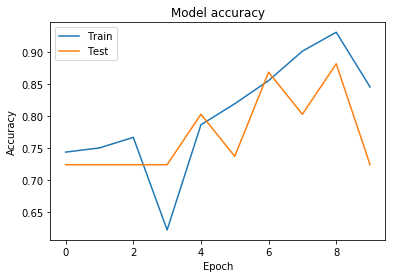

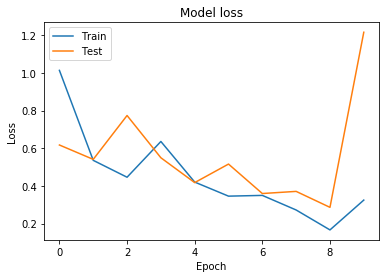

In [56]:
print('plot model')

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
# https://www.opencodez.com/python/text-classification-using-keras.htm
# Below code saves the model as well as tokenizer. We have to save our tokenizer because it is our vocabulary.
# The same tokenizer and vocabulary have to be used for accurate prediction.

# creates a HDF5 file
model.save('model.h5')

In [17]:
from keras.models import load_model

# load our saved model
model = load_model('model.h5')

# Display the confusion matrix

In [59]:
from sklearn.metrics import confusion_matrix

# Run classifier
y_pred = model.predict(x_val)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets